In [3]:
import os
from IPython.display import display

# check if this is a colab notebook and clone the repo if it is
if 'COLAB_GPU' in os.environ:
    %cd /content/
    !git clone https://github.com/Enver-group/twitch-web-analytics
    %cd twitch-web-analytics
    !pip install -r requirements.txt
    !pip install pyVis
    !pip install -e .
    %cd notebooks/


#autoreload modules
%load_ext autoreload
%autoreload 2

In [2]:
from src.graph_utils import get_k_common_followers, get_top_followers, plot_graph_pyVis, networkx_centrality_measures, draw_graph

For each user followed by Ibai we have a list of users he follows. The edge_weigths attributes of the following dataset represent the percentage of "similarity" between users followed by Ibai and all the users followed by those followed by Ibai. 

In [4]:
df = get_k_common_followers("../data/streamers.feather")
display(df)
plot_graph_pyVis(df,"ibai_common_followers.html")


137


,source,target,edge_weights
7,Ibai,IamCristinini,0.64
2,Ibai,TheGrefg,0.54
21,Ibai,elxokas,0.50
37,Ibai,CooLifeGame,0.50
99,Ibai,rubenmartinweb,0.48
...,...,...,...
15,Ibai,Reborn_Live,0.07
129,Ibai,Washosilva,0.06
109,Ibai,Nancla3,0.06
95,Ibai,snoodyboo,0.06


For the following dataframe, we have extracted the 15 most popular users followed by Ibai and for each of them filtered all their followers that are one of those 15 top users. Then, we have created a graph with this information.

In [7]:
df2 = get_top_followers("../data/streamers.feather")
display(df2)
plot_graph_pyVis(df2,"ibai_top_followers.html")

,source,target,edge_weigth
0,Ibai,auronplay,1
1,Ibai,Rubius,1
2,Ibai,TheGrefg,1
3,Ibai,juansguarnizo,1
4,Ibai,SLAKUN10,1
...,...,...,...
141,Luzu,auronplay,1
142,Luzu,IamCristinini,1
143,Luzu,LOLITOFDEZ,1
144,Luzu,Rubius,1


,eigenvector,betweenness,degree,degree_coefficient
Ibai,0.707107,1.0,1.000000,0
IamCristinini,0.065938,0.0,0.008696,0
TheGrefg,0.065938,0.0,0.008696,0
elxokas,0.065938,0.0,0.008696,0
CooLifeGame,0.065938,0.0,0.008696,0
...,...,...,...,...
Reborn_Live,0.065938,0.0,0.008696,0
Washosilva,0.065938,0.0,0.008696,0
Nancla3,0.065938,0.0,0.008696,0
snoodyboo,0.065938,0.0,0.008696,0


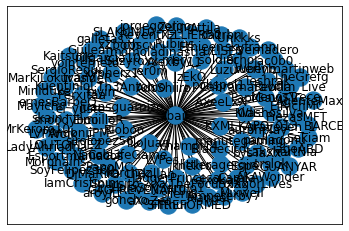

In [5]:
df1_centrality,G1 = networkx_centrality_measures(df)

display(df1_centrality)

draw_graph(G1)

,eigenvector,betweenness,degree,degree_coefficient
Ibai,0.300321,0.034358,1.000000,0.752381
auronplay,0.269928,0.019127,0.866667,0.807692
Rubius,0.300321,0.034358,1.000000,0.752381
TheGrefg,0.300321,0.034358,1.000000,0.752381
juansguarnizo,0.266238,0.024248,0.866667,0.769231
SLAKUN10,0.213319,0.008341,0.666667,0.844444
coscu,0.217355,0.006316,0.666667,0.866667
Alexby11,0.182058,0.000866,0.533333,0.964286
IamCristinini,0.300321,0.034358,1.000000,0.752381
LOLITOFDEZ,0.234588,0.010779,0.733333,0.836364


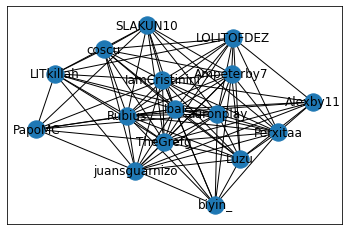

In [8]:
df2_centrality,G2 = networkx_centrality_measures(df2)

display(df2_centrality)

draw_graph(G2)  